In [1]:
# Install required libraries
!pip -q install torchsummary

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import InterpolationMode

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

import os
import sys

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla P100-PCIE-16GB is available


In [5]:
transforms = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(os.path.abspath('/kaggle/input/retinal-oct-large-v3/data/train'), transform=transforms)
val_data = ImageFolder(os.path.abspath('/kaggle/input/retinal-oct-large-v3/data/val'), transform=transforms)
test_data = ImageFolder(os.path.abspath('/kaggle/input/retinal-oct-large-v3/data/test'), transform=transforms)

In [6]:
# Select a sample
image, target = train_data[0]

In [7]:
# Inspect sample shape
image.shape

torch.Size([3, 224, 224])

In [8]:
# Summarize training data
train_data

Dataset ImageFolder
    Number of datapoints: 98648
    Root location: /kaggle/input/retinal-oct-large-v3/data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
val_data

Dataset ImageFolder
    Number of datapoints: 5194
    Root location: /kaggle/input/retinal-oct-large-v3/data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
# Summarize test data
test_data

Dataset ImageFolder
    Number of datapoints: 5467
    Root location: /kaggle/input/retinal-oct-large-v3/data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
# Class-Index relationship
train_data.class_to_idx

{'ABNORMAL': 0, 'NORMAL': 1}

Label: ABNORMAL


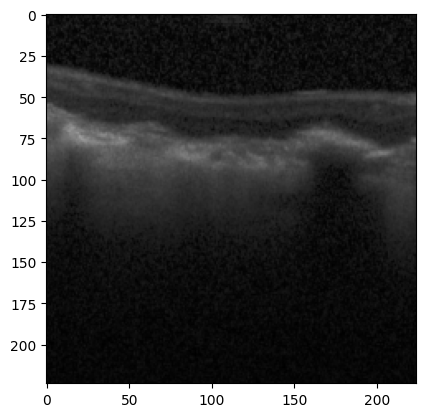

In [12]:
# Visualize a sample image
if target == 0:
    print(f"Label: ABNORMAL")
elif target == 1:
    print(f"Label: NORMAL")

# Define mean and std values used in normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Convert the tensor to a NumPy array
normalized_array = image.numpy()

# Transpose the array to have the channel dimension as the last axis
original_image = np.transpose(normalized_array, (1, 2, 0))

# Reverse normalization
original_image = (original_image * np.array(std)) + np.array(mean)

# Ensure pixel values are in the valid range [0, 1]
original_image = np.clip(original_image, 0, 1)

# Display the original image using Matplotlib
plt.imshow(original_image)
plt.show()

In [13]:
print(f'Number of NORMAL training images: {train_data.targets.count(1)}')
print(f'Number of ABNORMAL training images: {train_data.targets.count(0)}')

Number of NORMAL training images: 46379
Number of ABNORMAL training images: 52269


In [14]:
print(f'Number of NORMAL val images: {val_data.targets.count(1)}')
print(f'Number of ABNORMAL val images: {val_data.targets.count(0)}')

Number of NORMAL val images: 2441
Number of ABNORMAL val images: 2753


In [15]:
print(f'Number of NORMAL test images: {test_data.targets.count(1)}')
print(f'Number of ABNORMAL test images: {test_data.targets.count(0)}')

Number of NORMAL test images: 2570
Number of ABNORMAL test images: 2897


In [16]:
# Translate to dataloaders
train_loader = DataLoader(train_data, batch_size=512, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True, drop_last=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True, drop_last=False)

In [17]:
# Calculations for weighted loss function
class_weights = []
total_samples = len(train_data)

for i in range(len(train_data.classes)):
    class_samples = train_data.targets.count(i)
    weight_i = total_samples / (len(train_data.classes) * class_samples)
    class_weights.append(weight_i)

In [18]:
class_weights

[0.9436568520537986, 1.0634985661614094]

In [21]:
def calculate_metrics(yHat, y):
    # Convert the predictions to binary (0 or 1)
    predicted_classes = torch.argmax(yHat, axis=1)
    
    # True Positives, False Positives, False Negatives
    TP = torch.sum((predicted_classes == 1) & (y == 1)).item()
    FP = torch.sum((predicted_classes == 1) & (y == 0)).item()
    FN = torch.sum((predicted_classes == 0) & (y == 1)).item()

    # Calculate Accuracy, Precision, Recall, and F1 score
    accuracy = torch.mean((predicted_classes == y).float()).item()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate ROC-AUC score
    y_scores = torch.nn.functional.softmax(yHat, dim=1)[:, 1].cpu().detach().numpy()
    roc_auc = roc_auc_score(y.cpu().detach().numpy(), y_scores)

    return accuracy, precision, recall, f1, roc_auc

In [22]:
# Function to train the model
def train_the_model(net, lossfun, optimizer):
    # number of epochs
    numepochs = 5

    # Send the model to the GPU
    lossfun.to(device)

    # initialize Losses
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    
    # Intialize performance metrics 
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)
    
    trainRecall = torch.zeros(numepochs)
    valRecall = torch.zeros(numepochs)
    
    trainPrecision = torch.zeros(numepochs)
    valPrecision = torch.zeros(numepochs)
    
    trainF1 = torch.zeros(numepochs)
    valF1 = torch.zeros(numepochs)
    
    trainROC = torch.zeros(numepochs)
    valROC = torch.zeros(numepochs)
    

    # Loop over the epochs
    for epoch in range(numepochs):

        # Loop over training data batches
        net.train()
        batchLoss = []
        batchAcc = []
        batchRecall = []
        batchPrecision = []
        batchF1 = []
        batchROC = []
        
        # for (X,y), count in zip(train_loader, range(len(train_loader))):
        for (X,y), count in zip(train_loader, range(1, len(train_loader))):

            # Push the data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and performance from this batch
            accuracy, precision, recall, f1, roc_auc = calculate_metrics(yHat.cpu(), y.cpu())
            batchLoss.append(loss.item())
            batchAcc.append(accuracy)
            batchRecall.append(recall)
            batchPrecision.append(precision)
            batchF1.append(f1)
            batchROC.append(roc_auc)
            
            msg = 'Completed {}/{}'.format(count, len(train_loader))
            sys.stdout.write('\r' + msg)

        # and get average losses and accuracies across the batches
        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch]  = np.mean(batchAcc)
        trainRecall[epoch] = np.mean(batchRecall)
        trainPrecision[epoch] = np.mean(batchPrecision)
        trainF1[epoch] = np.mean(batchF1)
        trainROC[epoch] = np.mean(batchROC)
        
        # end of batch loop...

        # validation set performance
        net.eval() # switch to test mode
        batchLoss = []
        batchAcc = []
        batchRecall = []
        batchPrecision = []
        batchF1 = []
        batchROC = []
        
        # for (X,y), count in zip(val_loader, range(len(val_loader))):
        for (X,y), count in zip(val_loader, range(1, len(val_loader))):

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, y)

                # Loss and Performance from this batch
                accuracy, precision, recall, f1, roc_auc = calculate_metrics(yHat.cpu(), y.cpu())
                batchLoss.append(loss.item())
                batchAcc.append(accuracy)
                batchRecall.append(recall)
                batchPrecision.append(precision)
                batchF1.append(f1)
                batchROC.append(roc_auc)
            
                msg = 'Completed {}/{}'.format(count, len(val_loader))
                sys.stdout.write('\r' + msg)
                # end of batch loop...

        # and get average losses and accuracies across the batches
        valLoss[epoch] = np.mean(batchLoss)
        valAcc[epoch]  = np.mean(batchAcc)
        valRecall[epoch] = np.mean(batchRecall)
        valPrecision[epoch] = np.mean(batchPrecision)
        valF1[epoch] = np.mean(batchF1)
        valROC[epoch] = np.mean(batchROC)
        
        print(f' Epoch {epoch+1}/{numepochs}')
        # end epochs

    # function output
    return trainLoss, valLoss, trainAcc, valAcc, trainRecall, valRecall, trainPrecision, valPrecision, trainF1, valF1, trainROC, valROC, net

## **DenseNet121**

In [23]:
densenet121 = torchvision.models.densenet121(weights='IMAGENET1K_V1')
densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.3MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
# Freeze all layers except feed forward layers
for name, param in densenet121.named_parameters():
    if name not in ['classifier.weight', 'classifier.bias']:
        param.requires_grad = False

In [25]:
# Modify the final layer
densenet121.classifier = nn.Linear(1024, 2)

In [26]:
# Push the model to the GPU if available
densenet121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
# Define Loss Function and Optimizer
lossfun121 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
optimizer121 = torch.optim.Adam(densenet121.parameters(), lr=0.01, weight_decay=1e-3)

In [28]:
# Train the Model
trainLoss, valLoss, trainAcc, valAcc, trainRecall, valRecall, trainPrecision, valPrecision, trainF1, valF1, trainROC, valROC, densenet121 = train_the_model(densenet121, lossfun121, optimizer121)

Completed 20/2193 Epoch 1/5
Completed 20/2193 Epoch 2/5
Completed 20/2193 Epoch 3/5
Completed 20/2193 Epoch 4/5
Completed 20/2193 Epoch 5/5


In [29]:
densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

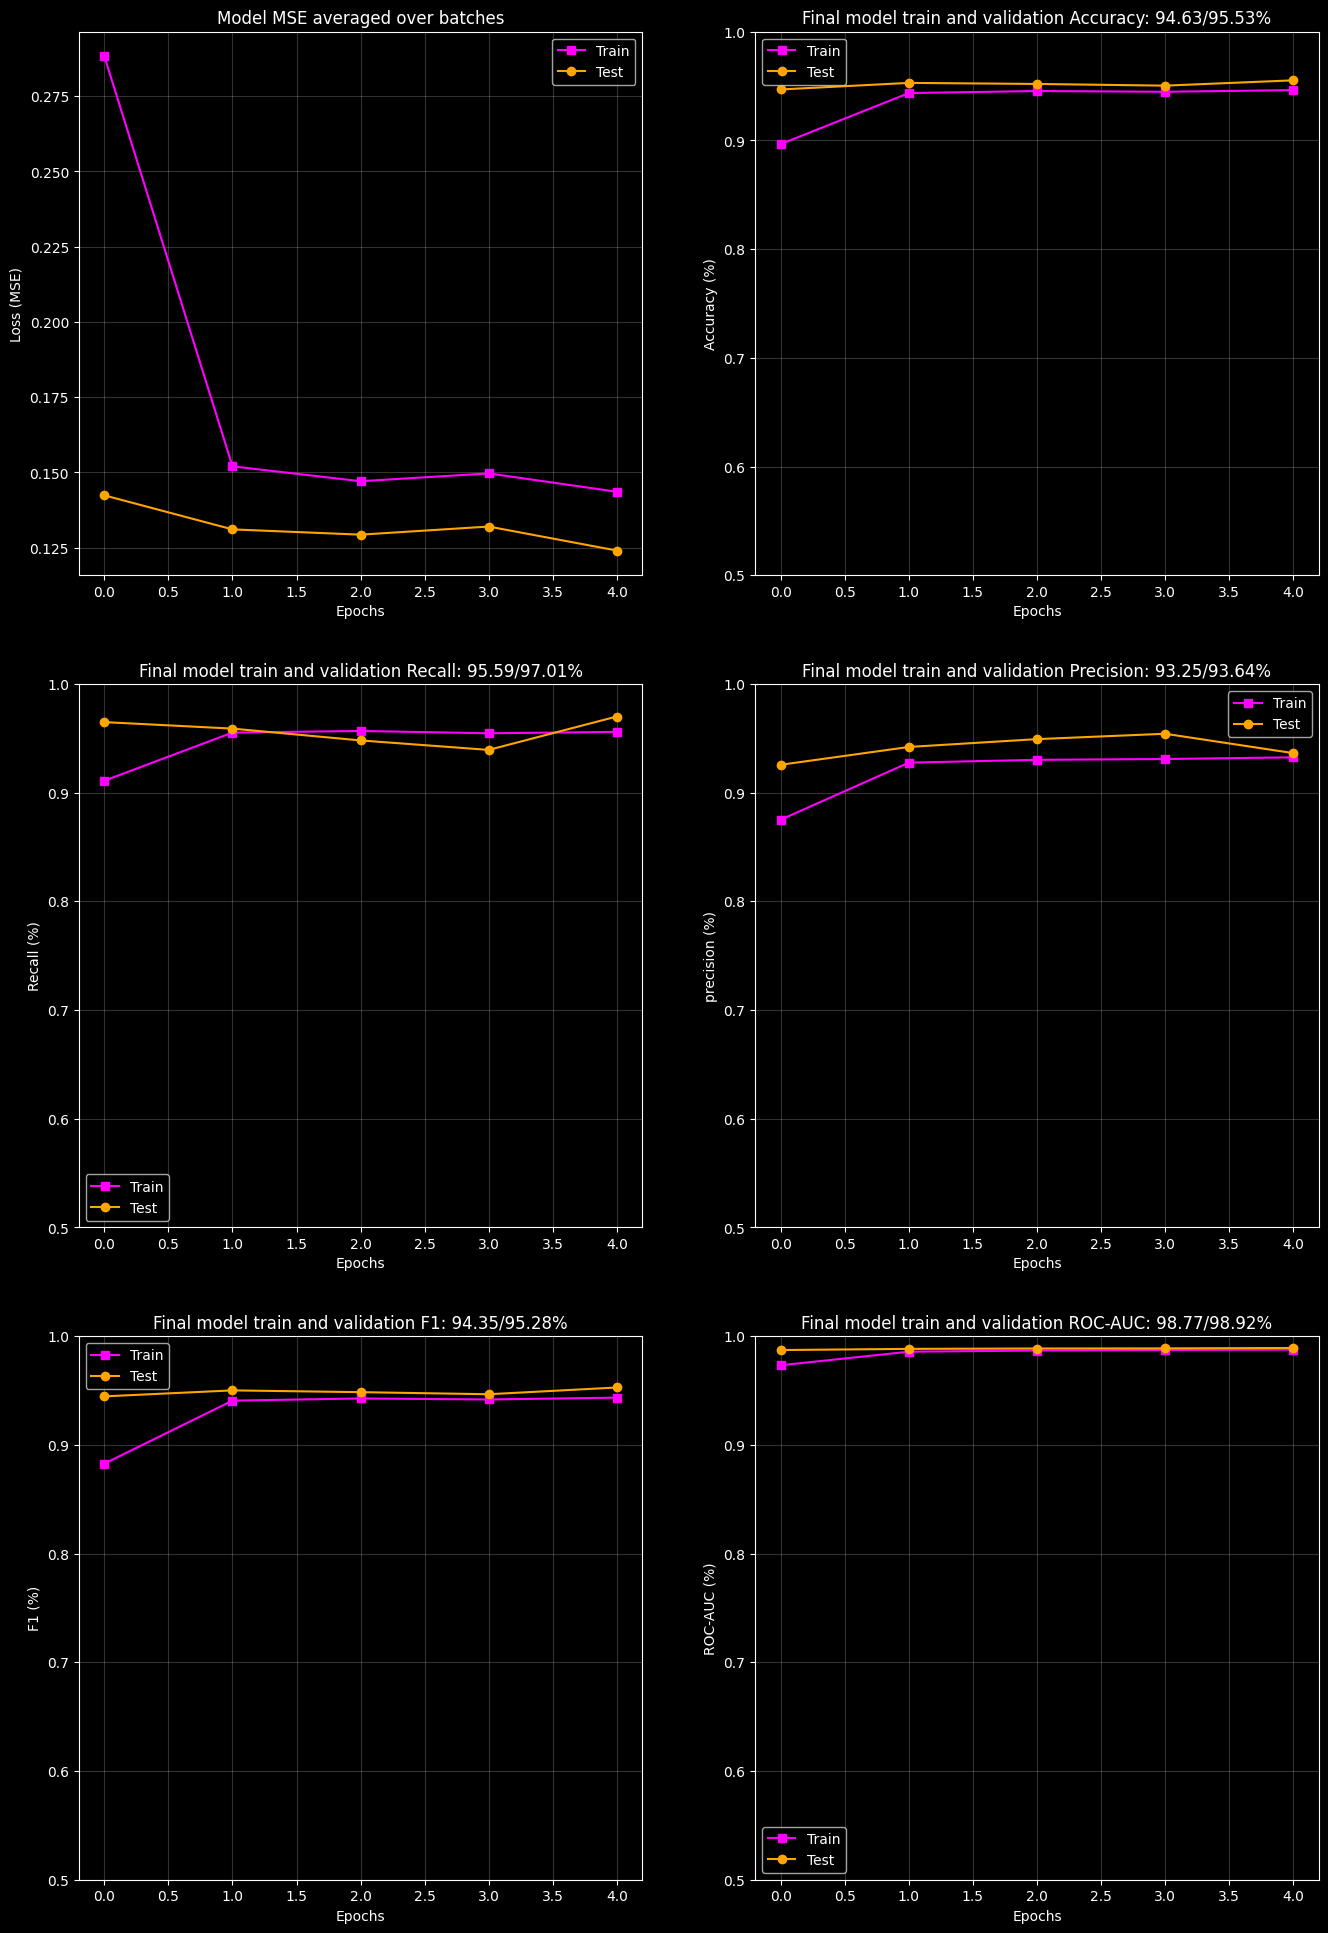

In [30]:
plt.style.use('dark_background')
fig, ax = plt.subplots(3, 2, figsize=(16, 24))

ax[0, 0].plot(trainLoss, 's-', label='Train', color='magenta')
ax[0, 0].plot(valLoss, 'o-', label='Test', color='orange')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss (MSE)')
ax[0, 0].set_title('Model MSE averaged over batches')
ax[0, 0].legend()
ax[0, 0].grid(alpha=0.2)

ax[0, 1].plot(trainAcc, 's-', label='Train', color='magenta')
ax[0, 1].plot(valAcc, 'o-', label='Test', color='orange')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy (%)')
ax[0, 1].set_title(f'Final model train and validation Accuracy: {trainAcc[-1]*100:.2f}/{valAcc[-1]*100:.2f}%')
ax[0, 1].set_ylim(0.5, 1)
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.2)

ax[1, 0].plot(trainRecall, 's-', label='Train', color='magenta')
ax[1, 0].plot(valRecall, 'o-', label='Test', color='orange')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Recall (%)')
ax[1, 0].set_title(f'Final model train and validation Recall: {trainRecall[-1]*100:.2f}/{valRecall[-1]*100:.2f}%')
ax[1, 0].set_ylim(0.5, 1)
ax[1, 0].legend()
ax[1, 0].grid(alpha=0.2)

ax[1, 1].plot(trainPrecision, 's-', label='Train', color='magenta')
ax[1, 1].plot(valPrecision, 'o-', label='Test', color='orange')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('precision (%)')
ax[1, 1].set_title(f'Final model train and validation Precision: {trainPrecision[-1]*100:.2f}/{valPrecision[-1]*100:.2f}%')
ax[1, 1].set_ylim(0.5, 1)
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.2)

ax[2, 0].plot(trainF1, 's-', label='Train', color='magenta')
ax[2, 0].plot(valF1, 'o-', label='Test', color='orange')
ax[2, 0].set_xlabel('Epochs')
ax[2, 0].set_ylabel('F1 (%)')
ax[2, 0].set_title(f'Final model train and validation F1: {trainF1[-1]*100:.2f}/{valF1[-1]*100:.2f}%')
ax[2, 0].set_ylim(0.5, 1)
ax[2, 0].legend()
ax[2, 0].grid(alpha=0.2)

ax[2, 1].plot(trainROC, 's-', label='Train', color='magenta')
ax[2, 1].plot(valROC, 'o-', label='Test', color='orange')
ax[2, 1].set_xlabel('Epochs')
ax[2, 1].set_ylabel('ROC-AUC (%)')
ax[2, 1].set_title(f'Final model train and validation ROC-AUC: {trainROC[-1]*100:.2f}/{valROC[-1]*100:.2f}%')
ax[2, 1].set_ylim(0.5, 1)
ax[2, 1].legend()
ax[2, 1].grid(alpha=0.2)


plt.savefig('/kaggle/working/performance.png')
plt.show()

In [31]:
torch.save(densenet121.state_dict(), '/kaggle/working/densenet121-oct-5metrics-v1.pt')

In [32]:
# Function to test the model on the test set
def test_the_model(net, lossfun, optimizer):

    # initialize Losses
    testLoss = torch.zeros(1)
    
    # Intialize performance metrics 
    testAcc = torch.zeros(1)
    testRecall = torch.zeros(1)
    testPrecision = torch.zeros(1)
    testF1 = torch.zeros(1)
    testROC = torch.zeros(1)

    # test set performance
    net.eval() # switch to test mode
    batchLoss = []
    batchAcc = []
    batchRecall = []
    batchPrecision = []
    batchF1 = []
    batchROC = []

    # for (X,y), count in zip(val_loader, range(len(val_loader))):
    for (X,y), count in zip(test_loader, range(1, len(test_loader))):

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat, y)

            # Loss and Performance from this batch
            accuracy, precision, recall, f1, roc_auc = calculate_metrics(yHat.cpu(), y.cpu())
            batchLoss.append(loss.item())
            batchAcc.append(accuracy)
            batchRecall.append(recall)
            batchPrecision.append(precision)
            batchF1.append(f1)
            batchROC.append(roc_auc)

            msg = 'Completed {}/{}'.format(count, len(test_loader))
            sys.stdout.write('\r' + msg)
            # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[0] = np.mean(batchLoss)
    testAcc[0]  = np.mean(batchAcc)
    testRecall[0] = np.mean(batchRecall)
    testPrecision[0] = np.mean(batchPrecision)
    testF1[0] = np.mean(batchF1)
    testROC[0] = np.mean(batchROC)

    # function output
    return testLoss, testAcc, testRecall, testPrecision, testF1, testROC

In [33]:
testLoss, testAcc, testRecall, testPrecision, testF1, testROC = test_the_model(densenet121, lossfun121, optimizer121)

Completed 21/22

In [34]:
testLoss

tensor([0.1337])

In [35]:
testAcc

tensor([0.9537])

In [36]:
testRecall

tensor([0.9667])

In [37]:
testPrecision

tensor([0.9367])

In [38]:
testF1

tensor([0.9512])

In [39]:
testROC

tensor([0.9875])